In [1]:
from model import *
import sys
import itertools
import numpy as np  # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Fancier plots
from sklearn.metrics import accuracy_score, classification_report

# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=1)

In [2]:
def create_sort_dataset(dataset_length, seq_length, max_number=999, fraction=0.8):
    x_train = np.random.randint(low=0, high=max_number+1, size=(int(dataset_length*fraction),
                                                                seq_length,
                                                                1))
    y_train = np.sort(x_train, axis=1)
    
    x_test = np.random.randint(low=0, high=max_number+1, size=(int(dataset_length*(1-fraction)),
                                                               seq_length,
                                                               1))
    y_test = np.sort(x_test, axis=1)
    
    return x_train, y_train, x_test, y_test

def create_dummy_dataset(dataset_length, seq_length, max_number):
    lower_bound = -1 * max_number
    x_train = np.random.randint(low=lower_bound, high=max_number+1, size=(dataset_length, seq_length, 1))
    y_train = np.where(x_train.sum(axis=2) > 0, 1, 0).reshape(x_train.shape)
    
    x_test = np.random.randint(low=lower_bound, high=max_number+1, size=(dataset_length, seq_length, 1))
    y_test = np.where(x_test.sum(axis=2) > 0, 1, 0).reshape(x_train.shape)
    
    return x_train, y_train, x_test, y_test

def evaluate(y_test, x_test, model):
    y_pred = model.predict(x_test)
    loss = model.loss(model.predict_proba(x_test), y_test)
    
    print(f'Cross entropy loss {loss}')
    print('-'*100)
    print(classification_report(y_test.flatten(), y_pred.flatten()))

In [5]:
# Set hyper-parameters
batch_size = 20  # Size of the minibatches (number of samples)
max_num = 10 
seq_length = 5
hidden_size = 10 
dataset_size = 200
epoch = 4

x_train, y_train, x_test, y_test = create_sort_dataset(dataset_size, seq_length, max_num)

input_size = 1
output_size = max_num+1

Epoch 1/4
TRAIN: Cross entropy loss:  2.5307617353409277
VALIDATION: Cross entropy loss:  2.5718785329512475
Epoch 2/4
TRAIN: Cross entropy loss:  2.4151134963712866
VALIDATION: Cross entropy loss:  2.510408643324758
Epoch 3/4
TRAIN: Cross entropy loss:  2.362500060425506
VALIDATION: Cross entropy loss:  2.466518959123873
Epoch 4/4
TRAIN: Cross entropy loss:  2.3237591749080555
VALIDATION: Cross entropy loss:  2.431801727443801


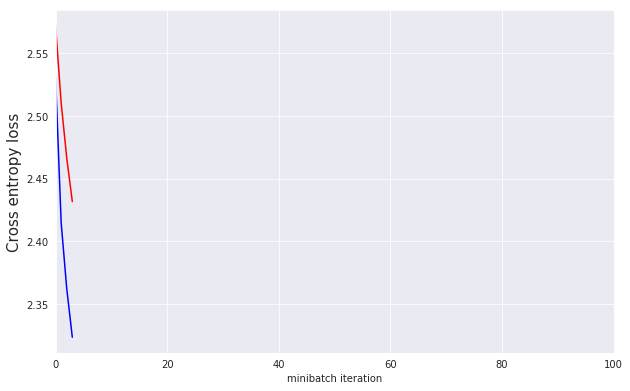

In [34]:
# Create the network
model = ModelSort(input_size, output_size, hidden_size, seq_length)

train_loss = []
validation_loss = []

for i in range(epoch):
    print(f'Epoch {i+1}/{epoch}')
    epoch_train_loss = []
    
    for mb in range(dataset_size // batch_size):
        x_batch = x_train[mb:mb + batch_size]  # Input minibatch
        y_batch = y_train[mb:mb + batch_size]  # Target minibatch
        model.train_on_batch(x_batch, y_batch)
        
        loss = model.loss(model.predict_proba(x_batch), y_batch)
        epoch_train_loss.append(loss)
        

    train_loss.append(np.mean(epoch_train_loss))
    validation_loss.append(model.loss(model.predict_proba(x_test), y_test))


    print("TRAIN: Cross entropy loss: ", train_loss[-1])
    print("VALIDATION: Cross entropy loss: ", validation_loss[-1])



# Plot the loss over the iterations
fig = plt.figure(figsize=(10, 7))
plt.plot(train_loss, 'b-')
plt.plot(validation_loss, 'r')
plt.xlabel('minibatch iteration')
plt.ylabel('Cross entropy loss', fontsize=15)
plt.xlim(0, 100)
fig.subplots_adjust(bottom=0.2)
plt.show()
#

In [35]:
evaluate(y_test, x_test, model)

Cross entropy loss 2.431801727443801
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.47      0.74      0.58        31
           1       0.00      0.00      0.00        35
           2       0.00      0.00      0.00        42
           3       0.12      0.21      0.15        39
           4       0.17      0.22      0.19        37
           5       0.00      0.00      0.00        39
           6       0.17      0.05      0.07        42
           7       0.06      0.08      0.07        25
           8       0.00      0.00      0.00        43
           9       0.06      0.22      0.09        27
          10       0.09      0.20      0.12        30

   micro avg       0.14      0.14      0.14       390
   macro avg       0.10      0.16      0.12       390
weighted avg       0.10      0.14      0.11       390



/home/loopdigga/Documents/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/loopdigga/Documents/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/loopdigga/Documents/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [6]:
# Do gradient checking
model = ModelSort(input_size, output_size, hidden_size, seq_length)
# Get the gradients of the parameters from a subset of the data
backprop_grads = model.get_gradients(
    x_train[:100], y_train[:100])

eps = 1e-9  # Set the small change to compute the numerical gradient
# Compute the numerical gradients of the parameters in all layers.
for p_idx, param in enumerate(model.get_params_iter()):
    grad_backprop = backprop_grads[p_idx]
    # + eps
    param += eps
    plus_loss = model.loss(
        model.predict_proba(x_train[0:100,:,:]), y_train[0:100,:,:])
    # - eps
    param -= 2 * eps
    min_loss = model.loss(
        model.predict_proba(x_train[0:100,:,:]), y_train[0:100,:,:])
    # reset param value
    param += eps
    # calculate numerical gradient
    grad_num = (plus_loss - min_loss) / (2*eps)
    # Raise error if the numerical grade is not close to the 
    #  backprop gradient
    if not np.isclose(grad_num, grad_backprop):
        print((
            f'Parameter id: {p_idx} '
            f'Numerical gradient of {grad_num:.6f} is not close '
            f'to the backpropagation gradient of {grad_backprop:.6f}!'
        ))

Parameter id: 0 Numerical gradient of 0.014847 is not close to the backpropagation gradient of 1.123312!
Parameter id: 1 Numerical gradient of 0.037006 is not close to the backpropagation gradient of 3.747619!
Parameter id: 2 Numerical gradient of 0.038063 is not close to the backpropagation gradient of 3.867195!
Parameter id: 3 Numerical gradient of 0.022023 is not close to the backpropagation gradient of 1.857961!
Parameter id: 4 Numerical gradient of -0.007457 is not close to the backpropagation gradient of -1.274286!
Parameter id: 5 Numerical gradient of -0.006492 is not close to the backpropagation gradient of -0.569035!
Parameter id: 6 Numerical gradient of -0.008934 is not close to the backpropagation gradient of -0.809759!
Parameter id: 7 Numerical gradient of -0.009676 is not close to the backpropagation gradient of -1.126236!
Parameter id: 8 Numerical gradient of -0.041648 is not close to the backpropagation gradient of -4.039855!
Parameter id: 9 Numerical gradient of 0.02531